In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
!pip install CatBoost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.2 MB/s 


In [ ]:
import catboost

## Data Preprocessing

In [ ]:
user_decision_df = pd.read_csv('user_decision.csv')
user_decision_df.head(7)

,user_id,period,decision_id
0,10625,1,409
1,10318,3,203
2,10775,4,420
3,10236,2,284
4,10130,3,72
5,10273,2,140
6,10617,3,329


In [ ]:
user_decision_df['decision_id'].value_counts()

386    1336
25      863
27      830
26      818
276     768
       ... 
7         4
233       3
346       2
261       1
258       1
Name: decision_id, Length: 343, dtype: int64

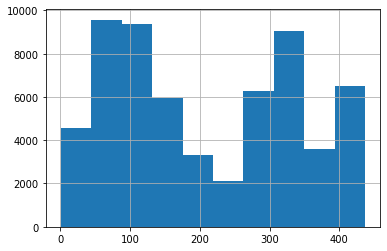

In [ ]:
user_decision_df['decision_id'].hist()

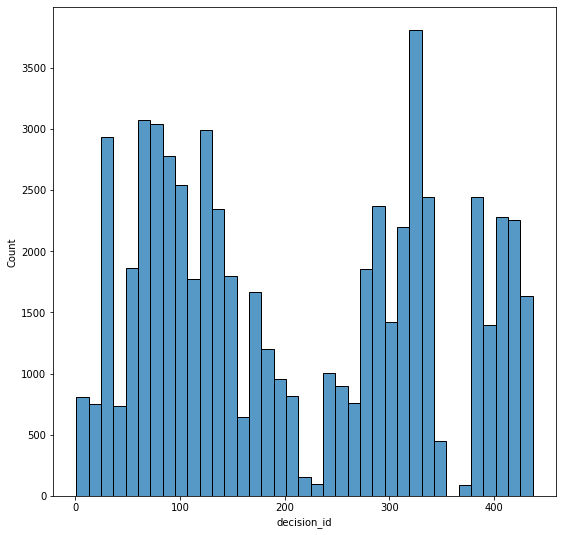

In [ ]:
plt.figure(figsize=(9,9))
sns.histplot(data=user_decision_df, x=user_decision_df['decision_id'])

Text(0, 0.5, 'decison_id')

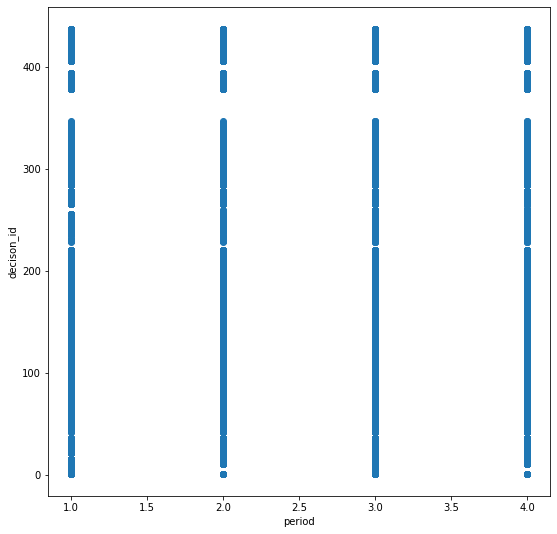

In [ ]:
plt.figure(figsize=(9,9))
plt.scatter(x=user_decision_df['period'], y=user_decision_df['decision_id'])
plt.xlabel('period')
plt.ylabel('decison_id')

In [ ]:
user_decision_df.shape

(60228, 3)

In [ ]:
user_decision_df.info

<bound method DataFrame.info of        user_id  period  decision_id
0        10625       1          409
1        10318       3          203
2        10775       4          420
3        10236       2          284
4        10130       3           72
...        ...     ...          ...
60223    10312       3          329
60224    10189       1           33
60225    10346       3          123
60226    10424       2          140
60227    10050       3          405

[60228 rows x 3 columns]>

In [ ]:
user_decision_df['period'].value_counts()

3    20964
4    14811
2    14453
1    10000
Name: period, dtype: int64

In [ ]:
decision_count = user_decision_df.groupby(['user_id', 'period'], as_index=False).count()
decision_count.head(10)

,user_id,period,decision_id
0,10001,1,29
1,10001,2,23
2,10001,3,39
3,10001,4,15
4,10002,2,9
5,10002,3,25
6,10002,4,22
7,10003,1,21
8,10003,2,41
9,10003,3,60


In [ ]:
decision_count.iloc[0]

id             10001
period             1
decision_id       29
Name: 0, dtype: int64

In [ ]:
m = {}
for i in range(len(decision_count)):
  if decision_count.iloc[i, 0] not in m:
    m[decision_count.iloc[i, 0]] =[(decision_count.iloc[i, 1], decision_count.iloc[i, 2])]
  else:
    m[decision_count.iloc[i, 0]].append((decision_count.iloc[i, 1], decision_count.iloc[i, 2]))

In [ ]:
m

{10001: [(1, 29), (2, 23), (3, 39), (4, 15)],
 10002: [(2, 9), (3, 25), (4, 22)],
 10003: [(1, 21), (2, 41), (3, 60), (4, 84)],
 10004: [(1, 3), (2, 19), (3, 41), (4, 27)],
 10005: [(1, 14), (2, 34), (3, 31)],
 10006: [(3, 8), (4, 10)],
 10007: [(1, 3), (2, 7), (3, 52), (4, 58)],
 10008: [(1, 16), (2, 25), (3, 43), (4, 7)],
 10009: [(1, 7), (2, 9), (3, 26), (4, 33)],
 10010: [(1, 10), (2, 19), (3, 17), (4, 10)],
 10011: [(3, 6)],
 10012: [(1, 2), (2, 2), (3, 4), (4, 3)],
 10013: [(1, 1), (4, 2)],
 10014: [(2, 25), (3, 28), (4, 23)],
 10015: [(1, 1), (2, 12), (3, 16), (4, 9)],
 10016: [(1, 3), (2, 3), (3, 3), (4, 1)],
 10017: [(1, 2), (2, 28), (3, 19), (4, 8)],
 10018: [(2, 2), (3, 3), (4, 1)],
 10019: [(3, 7), (4, 9)],
 10020: [(1, 31), (2, 30), (3, 56), (4, 8)],
 10021: [(1, 32), (2, 24), (3, 38), (4, 16)],
 10022: [(1, 16), (2, 19), (3, 20), (4, 73)],
 10023: [(1, 15), (2, 9), (4, 3)],
 10024: [(3, 3)],
 10025: [(1, 4), (2, 3), (3, 28), (4, 47)],
 10026: [(1, 2), (2, 6), (3, 4), (4, 

In [ ]:
train_df = pd.read_csv('train_dataset.csv')
train_df.head(7)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10884,4.0,4.0,4.0,4.0
1,10106,5.0,4.0,5.0,5.0
2,10438,6.0,5.0,5.0,5.0
3,10130,5.0,4.0,5.0,5.0
4,10667,4.0,5.0,5.0,5.0
5,10908,4.0,4.0,5.0,5.0
6,10378,4.0,5.0,5.0,4.0


In [ ]:
train_df.shape

(680, 5)

In [ ]:
train_df.head()

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10884,4.0,4.0,4.0,4.0
1,10106,5.0,4.0,5.0,5.0
2,10438,6.0,5.0,5.0,5.0
3,10130,5.0,4.0,5.0,5.0
4,10667,4.0,5.0,5.0,5.0


In [ ]:
for i in range(len(train_df)):
  now_id = train_df.iloc[i, 0]
  #print(now_id)
  has = []
  for j in range(len(m[now_id])):
    train_df.loc[i, 'period_'+str(m[now_id][j][0])] = m[now_id][j][1]
    has.append(m[now_id][j][0])
  has = sorted(has)
  for t in range(1, 5):
    if t not in has:
      train_df.iloc[i][t+4] = 0
      if t + 5 > 9:
        print(t + 5)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


In [ ]:
train_df.head(20)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus,period_1,period_2,period_3,period_4
0,10884,4.0,4.0,4.0,4.0,7.0,14.0,28.0,10.0
1,10106,5.0,4.0,5.0,5.0,21.0,21.0,12.0,8.0
2,10438,6.0,5.0,5.0,5.0,62.0,45.0,63.0,38.0
3,10130,5.0,4.0,5.0,5.0,26.0,28.0,34.0,66.0
4,10667,4.0,5.0,5.0,5.0,58.0,70.0,194.0,35.0
5,10908,4.0,4.0,5.0,5.0,NaN,4.0,10.0,7.0
6,10378,4.0,5.0,5.0,4.0,3.0,1.0,NaN,NaN
7,10220,5.0,4.0,5.0,5.0,1.0,NaN,2.0,1.0
8,10612,5.0,4.0,4.0,5.0,26.0,22.0,12.0,15.0
9,10776,4.0,4.0,5.0,5.0,16.0,13.0,37.0,36.0


In [ ]:
train_df = train_df.fillna(0)

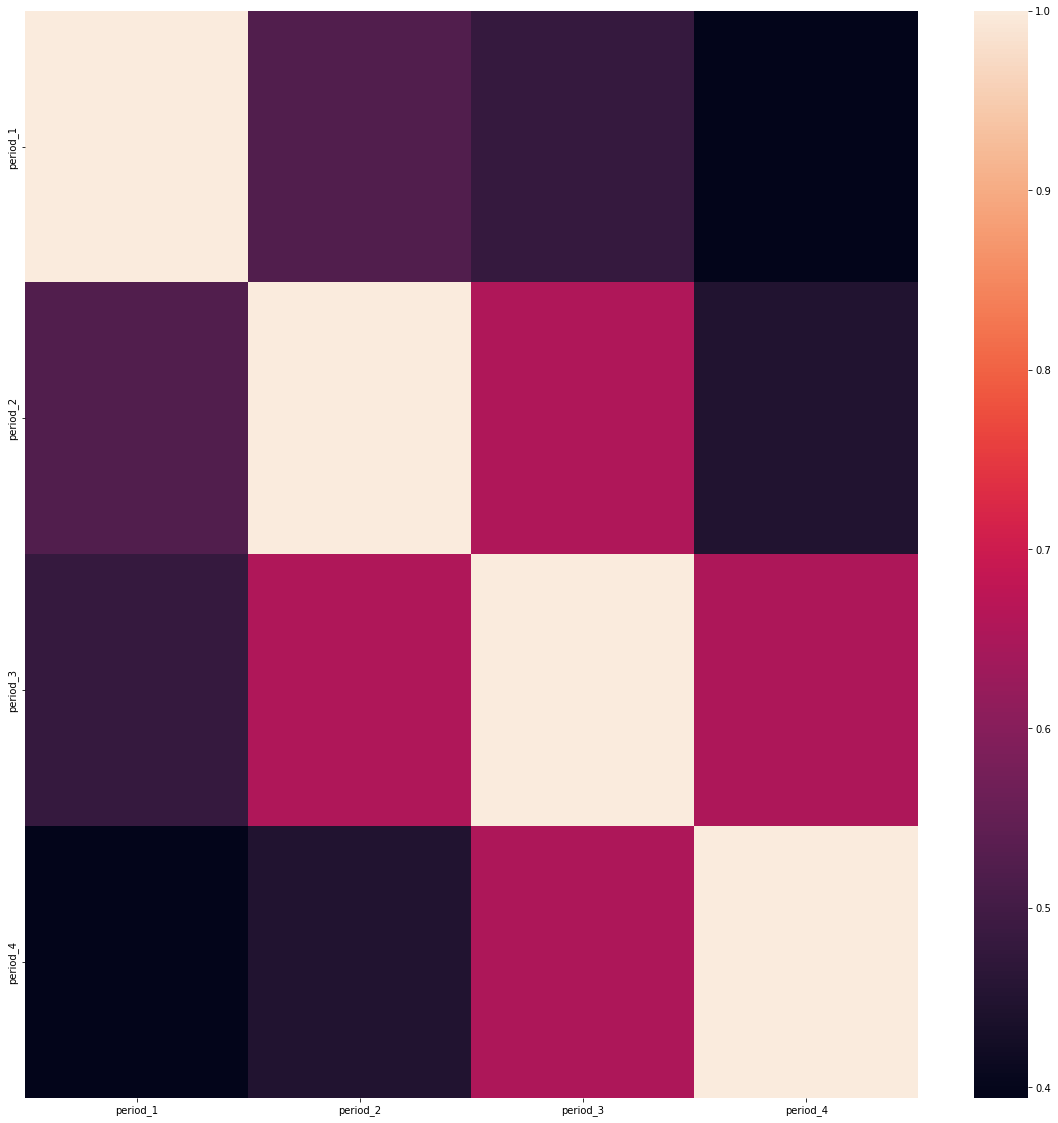

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(train_df.loc[:, 'period_1':'period_4'].corr())

In [ ]:
train_df.shape

(680, 9)

In [ ]:
train_df.isna().sum()

id                     0
Analytical thinking    0
Systemic thinking      0
Adaptability           0
Focus                  0
period_1               0
period_2               0
period_3               0
period_4               0
decision_count         0
dtype: int64

##Other Datasets

In [ ]:
team_df = pd.read_csv('team_point.csv')
team_df.head(7)

,team_id,category_id,period,score,place
0,1948,2,0,16,2
1,1934,3,4,45,6
2,1894,4,8,24,4
3,1688,4,0,27,4
4,1592,4,2,21,5
5,1344,5,0,8,6
6,1982,6,1,146,3


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


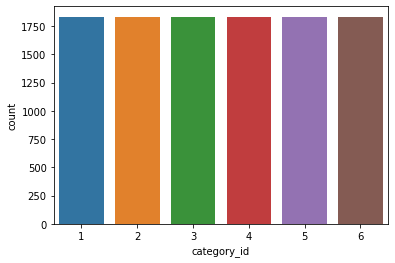

In [ ]:
sns.countplot(team_df['category_id'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


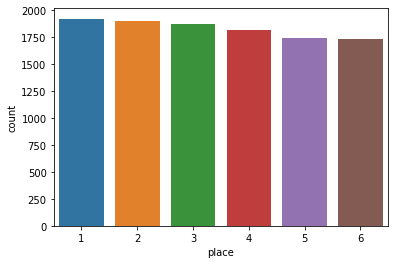

In [ ]:
sns.countplot(team_df['place'])

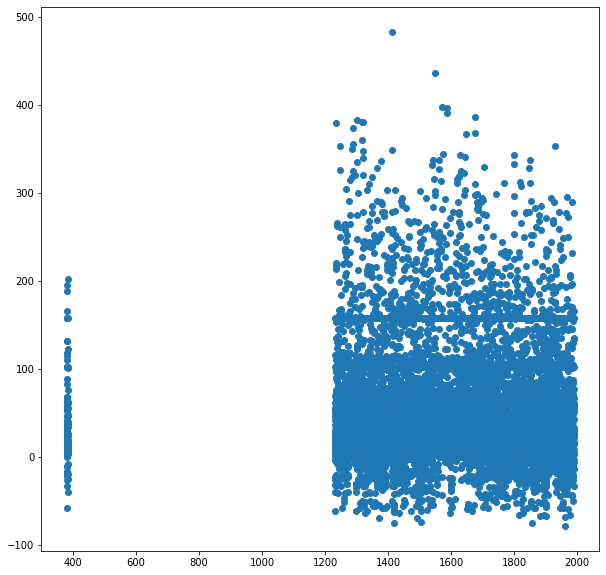

In [ ]:
plt.figure(figsize=(10, 10))

plt.scatter(x=team_df['team_id'], y=team_df['score'])

In [ ]:
team_df['score'].sort_index()

0        16
1        45
2        24
3        27
4        21
         ..
10981    32
10982     4
10983    31
10984    16
10985    28
Name: score, Length: 10986, dtype: int64

In [ ]:
np.sum(team_df[team_df['score'] < 0])

team_id        1564521
category_id       1555
period            3112
score           -19885
place             4808
dtype: int64

In [ ]:
#?team_df.loc[team_df['score'] < 0] = 0

In [ ]:
team_df['score'].value_counts()

0      1016
27      482
8       473
16      437
4       432
       ... 
327       1
397       1
344       1
319       1
349       1
Name: score, Length: 340, dtype: int64

In [ ]:
team_df['category_id'].value_counts()

2    1831
3    1831
4    1831
5    1831
6    1831
1    1831
Name: category_id, dtype: int64

In [ ]:
team_df['period'].value_counts()

4    2130
3    2130
2    2130
1    2130
0    2130
5     138
7      66
8      66
6      66
Name: period, dtype: int64

In [ ]:
team_df['place'].value_counts()

1    1922
2    1898
3    1874
4    1814
5    1740
6    1738
Name: place, dtype: int64

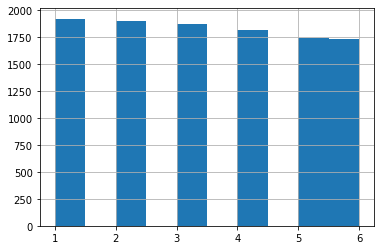

In [ ]:
team_df['place'].hist()

In [ ]:
about_user_df = pd.read_csv('user.csv')
about_user_df.head(7)

,user_id,team_id,game_id
0,10189,1664,235
1,10018,1690,237
2,10580,1394,194
3,10600,1908,262
4,10112,1592,219
5,10610,1446,202
6,10352,1734,241


In [ ]:
about_user_df[about_user_df['user_id'] == 10189]

,user_id,team_id,game_id
0,10189,1664,235


In [ ]:
about_user_df.shape

(973, 3)

In [ ]:
team_df[team_df['team_id'] == 1664]

,team_id,category_id,period,score,place
492,1664,3,1,105,2
642,1664,4,3,33,2
1340,1664,2,2,17,4
1718,1664,1,1,4,2
1778,1664,2,1,21,2
1856,1664,5,0,8,5
1863,1664,6,3,151,3
2141,1664,1,3,1,3
2715,1664,6,2,170,2
3065,1664,3,4,86,1


In [ ]:
team_df = team_df.sort_values(by=['period', 'score'], ascending=False)
team_df.head()

,team_id,category_id,period,score,place
10763,1414,6,8,349,1
6986,1422,6,8,280,2
8546,1902,6,8,236,1
7866,1896,6,8,192,2
4451,1416,6,8,170,3


In [ ]:
team_df['period'].value_counts()

4    2130
3    2130
2    2130
1    2130
0    2130
5     138
8      66
7      66
6      66
Name: period, dtype: int64

In [ ]:
for i in range(9):
  about_user_df['place'+str(i)] = 0
  #about_user_df['score'+str(i)] = 0

In [ ]:
about_user_df.head()

,user_id,team_id,game_id,place0,place1,place2,place3,place4,place5,place6,place7,place8
0,10189,1664,235,0,0,0,0,0,0,0,0,0
1,10018,1690,237,0,0,0,0,0,0,0,0,0
2,10580,1394,194,0,0,0,0,0,0,0,0,0
3,10600,1908,262,0,0,0,0,0,0,0,0,0
4,10112,1592,219,0,0,0,0,0,0,0,0,0


In [ ]:
team_df.head(3)

,team_id,category_id,period,score,place
10763,1414,6,8,349,1
6986,1422,6,8,280,2
8546,1902,6,8,236,1


In [ ]:
team_df['place'].value_counts()

1    1922
2    1898
3    1874
4    1814
5    1740
6    1738
Name: place, dtype: int64

In [ ]:
#7-беск
m_place_for_per = {}
for i in range(len(team_df)):
  now_team = team_df.iloc[i, 0]
  if team_df.iloc[i, 0] not in m_place_for_per:
    m_place_for_per[now_team] = [7] * 9
    m_place_for_per[now_team][team_df.iloc[i, 2]] = team_df.iloc[i, 4]
  else:
    m_place_for_per[now_team][team_df.iloc[i, 2]]= min(m_place_for_per[now_team][team_df.iloc[i, 2]], team_df.iloc[i, 4])

In [ ]:
team_df.head(3)

,team_id,category_id,period,score,place
10763,1414,6,8,349,1
6986,1422,6,8,280,2
8546,1902,6,8,236,1


In [ ]:
about_user_df.tail()

,user_id,team_id,game_id,place0,place1,place2,place3,place4,place5,place6,place7,place8
968,10205,1826,249,0,0,0,0,0,0,0,0,0
969,10325,1628,231,0,0,0,0,0,0,0,0,0
970,10527,1730,241,0,0,0,0,0,0,0,0,0
971,10371,1704,238,0,0,0,0,0,0,0,0,0
972,10471,1518,209,0,0,0,0,0,0,0,0,0


In [ ]:
for i in range(len(about_user_df)):
    for j in range(9):
      now_team = about_user_df.iloc[i, 1]
      about_user_df.loc[i, 'place'+str(j)] = m_place_for_per[now_team][j]

In [ ]:
about_user_df.tail(5)

,user_id,team_id,game_id,place0,place1,place2,place3,place4,place5,place6,place7,place8
968,10205,1826,249,2,1,2,4,4,7,7,7,7
969,10325,1628,231,2,1,1,1,1,7,7,7,7
970,10527,1730,241,1,2,2,2,2,7,7,7,7
971,10371,1704,238,6,2,3,3,1,7,7,7,7
972,10471,1518,209,3,1,1,1,1,7,7,7,7


In [ ]:
m_place_for_per[1730]

[1, 2, 2, 2, 2, 7, 7, 7, 7]

In [ ]:
about_user_df = about_user_df.rename(columns={'user_id':'id'})
about_user_df.head(3)

,id,team_id,game_id,place0,place1,place2,place3,place4,place5,place6,place7,place8
0,10189,1664,235,5,1,1,1,1,7,7,7,7
1,10018,1690,237,2,2,2,2,1,7,7,7,7
2,10580,1394,194,4,2,3,4,4,7,7,7,7


In [ ]:
train_df.head(5)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus,period_1,period_2,period_3,period_4
0,10884,4.0,4.0,4.0,4.0,7.0,14.0,28.0,10.0
1,10106,5.0,4.0,5.0,5.0,21.0,21.0,12.0,8.0
2,10438,6.0,5.0,5.0,5.0,62.0,45.0,63.0,38.0
3,10130,5.0,4.0,5.0,5.0,26.0,28.0,34.0,66.0
4,10667,4.0,5.0,5.0,5.0,58.0,70.0,194.0,35.0


In [ ]:
train_df = train_df.merge(about_user_df, how='left', on='id')
train_df.head(5)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus,period_1,period_2,period_3,period_4,team_id,game_id,place0,place1,place2,place3,place4,place5,place6,place7,place8
0,10884,4.0,4.0,4.0,4.0,7.0,14.0,28.0,10.0,1440,202,3,1,2,3,2,7,7,7,7
1,10106,5.0,4.0,5.0,5.0,21.0,21.0,12.0,8.0,1536,211,5,1,1,1,2,7,7,7,7
2,10438,6.0,5.0,5.0,5.0,62.0,45.0,63.0,38.0,1742,242,3,2,1,1,2,7,7,7,7
3,10130,5.0,4.0,5.0,5.0,26.0,28.0,34.0,66.0,1272,184,1,2,1,2,2,7,7,7,7
4,10667,4.0,5.0,5.0,5.0,58.0,70.0,194.0,35.0,1382,193,4,1,1,3,1,7,7,7,7


In [ ]:
train_df = train_df.drop(columns=['team_id', 'game_id'], axis=1)
train_df.head(3)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus,period_1,period_2,period_3,period_4,place0,place1,place2,place3,place4,place5,place6,place7,place8
0,10884,4.0,4.0,4.0,4.0,7.0,14.0,28.0,10.0,3,1,2,3,2,7,7,7,7
1,10106,5.0,4.0,5.0,5.0,21.0,21.0,12.0,8.0,5,1,1,1,2,7,7,7,7
2,10438,6.0,5.0,5.0,5.0,62.0,45.0,63.0,38.0,3,2,1,1,2,7,7,7,7


In [ ]:
train_df['Analytical thinking'].value_counts()

4.0    417
5.0    209
3.0     36
6.0     14
1.0      4
Name: Analytical thinking, dtype: int64

In [ ]:
#train_df.loc[(train_df['Analytical thinking'] == 3.0) | (train_df['Analytical thinking'] == 6.0) | (train_df['Analytical thinking'] == 1.0)] = 5.0

In [ ]:
train_df['Systemic thinking'].value_counts()

4.0    491
5.0    124
3.0     51
6.0     10
1.0      4
Name: Systemic thinking, dtype: int64

In [ ]:
#train_df.loc[(train_df['Systemic thinking'] == 1.0) | (train_df['Systemic thinking'] == 6.0) | (train_df['Systemic thinking'] == 3.0)] = 5.0

In [ ]:
train_df['Adaptability'].value_counts()

5.0    318
4.0    308
3.0     36
6.0     15
1.0      2
2.0      1
Name: Adaptability, dtype: int64

In [ ]:
#train_df.loc[train_df['Adaptability'] == 3.0] = 4.0
#train_df.loc[(train_df['Adaptability'] == 6.0) | (train_df['Adaptability'] == 1.0) | (train_df['Adaptability'] == 2.0)] = 5.0

In [ ]:
train_df['Focus'].value_counts()

4.0    400
5.0    244
3.0     29
6.0      3
1.0      3
2.0      1
Name: Focus, dtype: int64

In [ ]:
#train_df.loc[(train_df['Focus'] == 3.0) | (train_df['Focus'] == 6.0) | (train_df['Focus'] == 1.0) | (train_df['Focus'] == 2.0)] = 5.0

In [ ]:
train_df['Focus'].value_counts()

4.0    354
5.0    326
Name: Focus, dtype: int64

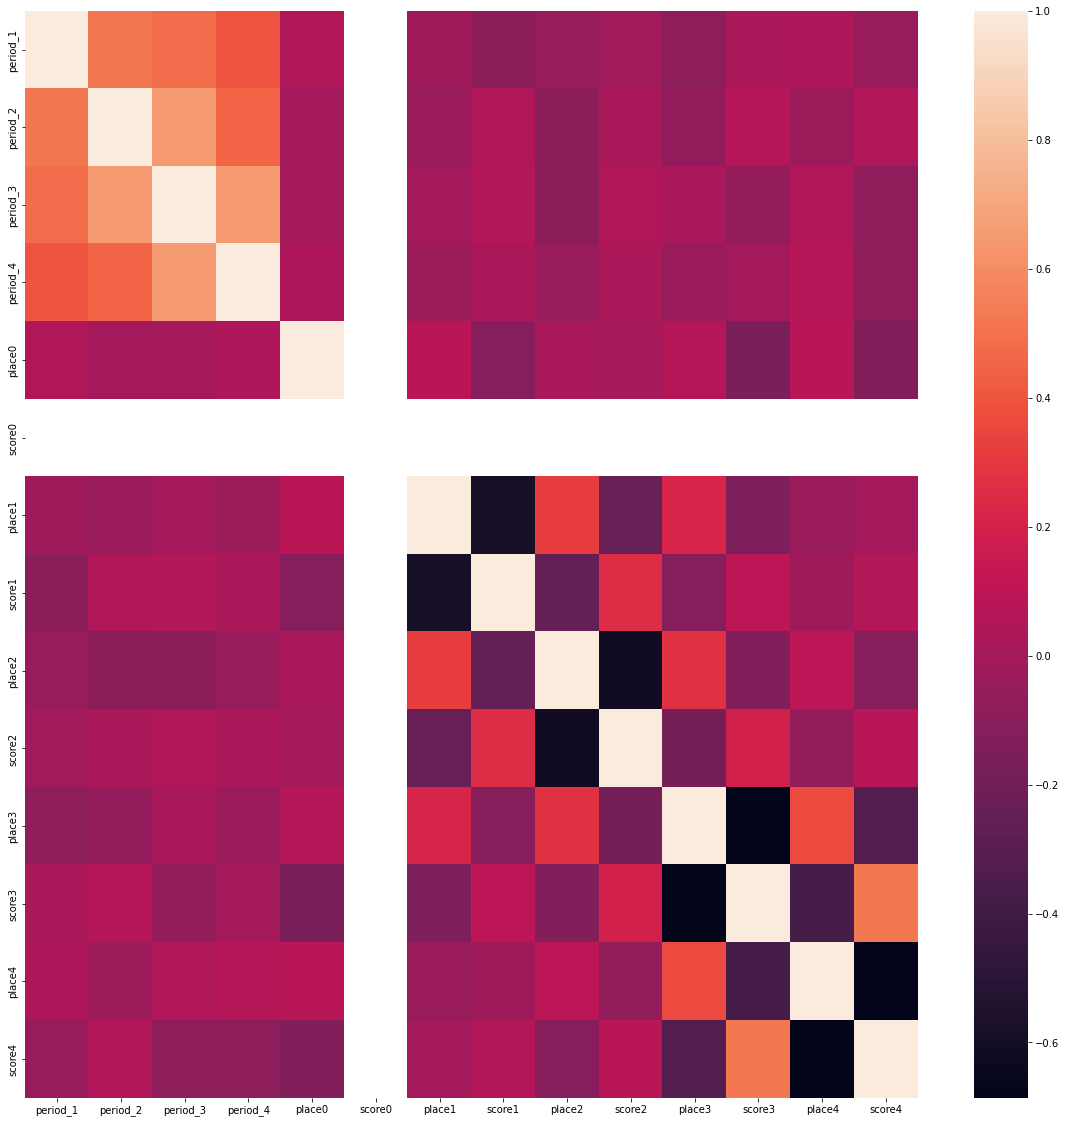

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(train_df.loc[:, 'period_1':'score4'].corr())

In [ ]:
dec_xlsx_df = pd.read_excel('decision.xlsx')
dec_xlsx_df.head()

,decision_id,decision_name,Unnamed: 2
0,1,Dividend payout in cash,NaN
1,2,Dividend payout in stocks,NaN
2,3,Zero dividend policy,NaN
3,4,The distribution of the residue after the rein...,NaN
4,5,Fixed size of dividend payouts sum,NaN


In [ ]:
dec_xlsx_df = dec_xlsx_df.drop(columns=['Unnamed: 2'])
dec_xlsx_df.head()

,decision_id,decision_name
0,1,Dividend payout in cash
1,2,Dividend payout in stocks
2,3,Zero dividend policy
3,4,The distribution of the residue after the rein...
4,5,Fixed size of dividend payouts sum


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


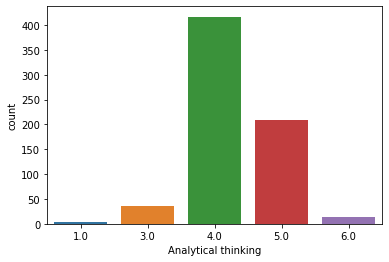

In [ ]:
sns.countplot(train_df['Analytical thinking'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


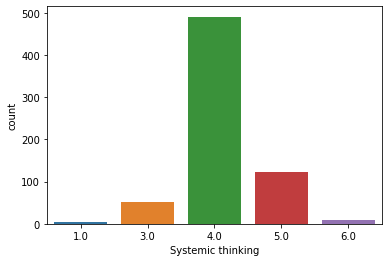

In [ ]:
sns.countplot(train_df['Systemic thinking'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


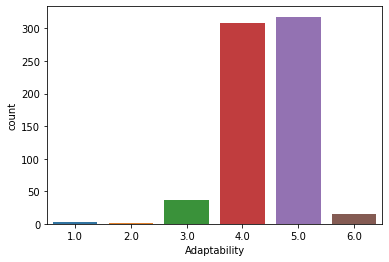

In [ ]:
sns.countplot(train_df['Adaptability'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


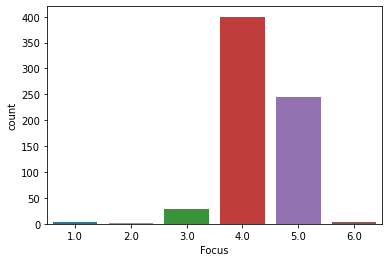

In [ ]:
sns.countplot(train_df['Focus'])

## Before Training

In [ ]:
train_df.head(4)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus,period_1,period_2,period_3,period_4,place0,place1,place2,place3,place4,place5,place6,place7,place8
0,10884,4.0,4.0,4.0,4.0,7.0,14.0,28.0,10.0,3,1,2,3,2,7,7,7,7
1,10106,5.0,4.0,5.0,5.0,21.0,21.0,12.0,8.0,5,1,1,1,2,7,7,7,7
2,10438,6.0,5.0,5.0,5.0,62.0,45.0,63.0,38.0,3,2,1,1,2,7,7,7,7
3,10130,5.0,4.0,5.0,5.0,26.0,28.0,34.0,66.0,1,2,1,2,2,7,7,7,7


In [ ]:
train_df.isnull().sum()

id                     0
Analytical thinking    0
Systemic thinking      0
Adaptability           0
Focus                  0
period_1               0
period_2               0
period_3               0
period_4               0
place0                 0
place1                 0
place2                 0
place3                 0
place4                 0
place5                 0
place6                 0
place7                 0
place8                 0
dtype: int64

In [ ]:
y = train_df.loc[:, 'Analytical thinking':'Focus']
y

,Analytical thinking,Systemic thinking,Adaptability,Focus
0,4.0,4.0,4.0,4.0
1,5.0,4.0,5.0,5.0
2,6.0,5.0,5.0,5.0
3,5.0,4.0,5.0,5.0
4,4.0,5.0,5.0,5.0
...,...,...,...,...
675,5.0,4.0,5.0,4.0
676,5.0,4.0,5.0,5.0
677,5.0,4.0,5.0,4.0
678,4.0,4.0,4.0,4.0


In [ ]:
X = train_df.loc[:, 'period_1':'place8']
X

,period_1,period_2,period_3,period_4,place0,place1,place2,place3,place4,place5,place6,place7,place8
0,7.0,14.0,28.0,10.0,3,1,2,3,2,7,7,7,7
1,21.0,21.0,12.0,8.0,5,1,1,1,2,7,7,7,7
2,62.0,45.0,63.0,38.0,3,2,1,1,2,7,7,7,7
3,26.0,28.0,34.0,66.0,1,2,1,2,2,7,7,7,7
4,58.0,70.0,194.0,35.0,4,1,1,3,1,7,7,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,10.0,2.0,14.0,4.0,4,2,3,4,3,7,7,7,7
676,1.0,14.0,24.0,1.0,2,1,3,1,1,7,7,7,7
677,4.0,17.0,23.0,12.0,1,1,3,2,1,7,7,7,7
678,10.0,44.0,45.0,38.0,1,2,2,2,3,7,7,7,7


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y['Analytical thinking'], test_size=0.25, random_state=42)

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y['Systemic thinking'], test_size=0.25, random_state=42)

In [ ]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y['Adaptability'], test_size=0.25, random_state=42)

In [ ]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y['Focus'], test_size=0.25, random_state=42)

## Training and Tune models

In [ ]:
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [ ]:
#####

In [ ]:
clf1 = CatBoostClassifier(iterations=10000, learning_rate=0.01, depth=10)
clf2 = CatBoostClassifier(iterations=10000, learning_rate=0.01, depth=10)
clf3 = CatBoostClassifier(iterations=10000, learning_rate=0.01, depth=10)
clf4 = CatBoostClassifier(iterations=10000, learning_rate=0.01, depth=10)

In [ ]:
clf1.fit(X_train1, y_train1)
clf2.fit(X_train2, y_train2)
clf3.fit(X_train3, y_train3)
clf4.fit(X_train4, y_train4)

Streaming output truncated to the last 5000 lines.
5000:	learn: 0.0544015	total: 1m 34s	remaining: 1m 34s
5001:	learn: 0.0543887	total: 1m 34s	remaining: 1m 34s
5002:	learn: 0.0543774	total: 1m 34s	remaining: 1m 34s
5003:	learn: 0.0543648	total: 1m 34s	remaining: 1m 34s
5004:	learn: 0.0543505	total: 1m 34s	remaining: 1m 34s
5005:	learn: 0.0543367	total: 1m 34s	remaining: 1m 34s
5006:	learn: 0.0543224	total: 1m 34s	remaining: 1m 34s
5007:	learn: 0.0543072	total: 1m 34s	remaining: 1m 34s
5008:	learn: 0.0542958	total: 1m 34s	remaining: 1m 34s
5009:	learn: 0.0542845	total: 1m 34s	remaining: 1m 34s
5010:	learn: 0.0542687	total: 1m 34s	remaining: 1m 34s
5011:	learn: 0.0542584	total: 1m 34s	remaining: 1m 33s
5012:	learn: 0.0542443	total: 1m 34s	remaining: 1m 33s
5013:	learn: 0.0542291	total: 1m 34s	remaining: 1m 33s
5014:	learn: 0.0542176	total: 1m 34s	remaining: 1m 33s
5015:	learn: 0.0542049	total: 1m 34s	remaining: 1m 33s
5016:	learn: 0.0541937	total: 1m 34s	remaining: 1m 33s
5017:	learn: 0

In [ ]:
pr1 = clf1.predict(X_test1)
pr2 = clf2.predict(X_test2)
pr3 = clf3.predict(X_test3)
pr4 = clf4.predict(X_test4)

In [ ]:
r1 = 0.25 * recall_score(y_test1, pr1, average='macro', zero_division=True) + \
 0.25 * recall_score(y_test2, pr2, average='macro', zero_division=True) + \
        0.25 * recall_score(y_test3, pr3, average='macro', zero_division=True) + \
        0.25 * recall_score(y_test4, pr4, average='macro', zero_division=True) 
        

In [ ]:
r1

0.31589492898086646

In [ ]:
p1 = pd.DataFrame(clf1.predict(X), columns=['pred_analit'])
p2 = pd.DataFrame(clf2.predict(X), columns=['pred_system'])
p3 = pd.DataFrame(clf3.predict(X), columns=['pred_adapt'])
p4 = pd.DataFrame(clf4.predict(X), columns=['pred_focus'])

In [ ]:
p1.value_counts()

pred_analit
4.0            450
5.0            192
3.0             26
6.0              8
1.0              4
dtype: int64

In [ ]:
X.head()

,period_1,period_2,period_3,period_4,place0,place1,place2,place3,place4,place5,place6,place7,place8
0,7.0,14.0,28.0,10.0,3,1,2,3,2,7,7,7,7
1,21.0,21.0,12.0,8.0,5,1,1,1,2,7,7,7,7
2,62.0,45.0,63.0,38.0,3,2,1,1,2,7,7,7,7
3,26.0,28.0,34.0,66.0,1,2,1,2,2,7,7,7,7
4,58.0,70.0,194.0,35.0,4,1,1,3,1,7,7,7,7


In [ ]:
X_new = pd.concat([X, p1, p2, p3, p4], axis=1)
X_new

,period_1,period_2,period_3,period_4,place0,place1,place2,place3,place4,place5,place6,place7,place8,pred_analit,pred_system,pred_adapt,pred_focus
0,7.0,14.0,28.0,10.0,3,1,2,3,2,7,7,7,7,4.0,4.0,4.0,4.0
1,21.0,21.0,12.0,8.0,5,1,1,1,2,7,7,7,7,5.0,4.0,5.0,5.0
2,62.0,45.0,63.0,38.0,3,2,1,1,2,7,7,7,7,5.0,4.0,5.0,5.0
3,26.0,28.0,34.0,66.0,1,2,1,2,2,7,7,7,7,5.0,4.0,5.0,5.0
4,58.0,70.0,194.0,35.0,4,1,1,3,1,7,7,7,7,4.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,10.0,2.0,14.0,4.0,4,2,3,4,3,7,7,7,7,4.0,4.0,4.0,4.0
676,1.0,14.0,24.0,1.0,2,1,3,1,1,7,7,7,7,5.0,4.0,5.0,4.0
677,4.0,17.0,23.0,12.0,1,1,3,2,1,7,7,7,7,5.0,4.0,5.0,4.0
678,10.0,44.0,45.0,38.0,1,2,2,2,3,7,7,7,7,5.0,4.0,5.0,5.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25, random_state=42)

In [ ]:
#max_depth=12-best
clf = RandomForestClassifier(n_estimators=15000, max_depth=12, min_samples_split=2,random_state=42)

In [ ]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, n_estimators=15000, random_state=42)

In [ ]:
pred = clf.predict(X_test)

In [ ]:
from sklearn.metrics import recall_score

In [ ]:
result = 0.25 * recall_score(y_test['Analytical thinking'], pred[:, 0], average='macro', zero_division=True) + \
 0.25 * recall_score(y_test['Systemic thinking'], pred[:, 1], average='macro', zero_division=True) + \
        0.25 * recall_score(y_test['Adaptability'], pred[:, 2], average='macro', zero_division=True) + \
        0.25 * recall_score(y_test['Focus'], pred[:, 3], average='macro', zero_division=True) 
        

In [ ]:
result

0.28068222501816253

In [ ]:
#prev:0.2725921208343083 (18000)

##Get answer

In [ ]:
sample_df = pd.read_csv('sample_solution.csv')
sample_df.head()

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10199,0,0,0,0
1,10539,0,0,0,0
2,10174,0,0,0,0
3,10465,0,0,0,0
4,10066,0,0,0,0


In [ ]:
sample_df.shape

(293, 8)

In [ ]:
for i in range(len(sample_df)):
  now_id = sample_df.iloc[i, 0]
  #print(now_id)
  has = []
  for j in range(len(m[now_id])):
    sample_df.loc[i, 'period_'+str(m[now_id][j][0])] = m[now_id][j][1]
    has.append(m[now_id][j][0])
  has = sorted(has)
  for t in range(1, 5):
    if t not in has:
      sample_df.iloc[i][t+4] = 0
      if t + 5 > 9:
        print(t + 5)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


In [ ]:
about_user_df.head(3)

,id,team_id,game_id,place0,place1,place2,place3,place4,place5,place6,place7,place8
0,10189,1664,235,5,1,1,1,1,7,7,7,7
1,10018,1690,237,2,2,2,2,1,7,7,7,7
2,10580,1394,194,4,2,3,4,4,7,7,7,7


In [ ]:
sample_df.head(20)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus,period_1,period_2,period_3,period_4
0,10199,0,0,0,0,2.0,2.0,3.0,2.0
1,10539,0,0,0,0,1.0,9.0,15.0,17.0
2,10174,0,0,0,0,NaN,28.0,31.0,20.0
3,10465,0,0,0,0,15.0,18.0,32.0,18.0
4,10066,0,0,0,0,8.0,23.0,16.0,6.0
5,10425,0,0,0,0,2.0,NaN,7.0,4.0
6,10398,0,0,0,0,2.0,44.0,40.0,30.0
7,10346,0,0,0,0,16.0,19.0,24.0,4.0
8,10281,0,0,0,0,2.0,6.0,12.0,9.0
9,10158,0,0,0,0,3.0,6.0,1.0,7.0


In [ ]:
about_user_df.head()

,id,team_id,game_id,place0,place1,place2,place3,place4,place5,place6,place7,place8
0,10189,1664,235,5,1,1,1,1,7,7,7,7
1,10018,1690,237,2,2,2,2,1,7,7,7,7
2,10580,1394,194,4,2,3,4,4,7,7,7,7
3,10600,1908,262,1,1,3,1,1,7,7,7,7
4,10112,1592,219,2,2,2,1,1,7,7,7,7


In [ ]:
sample_df = sample_df.merge(about_user_df, how='left', on='id')
sample_df.head(5)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus,period_1,period_2,period_3,period_4,team_id,game_id,place0,place1,place2,place3,place4,place5,place6,place7,place8
0,10199,0,0,0,0,2.0,2.0,3.0,2.0,1912,262,5,1,1,1,3,7,7,7,7
1,10539,0,0,0,0,1.0,9.0,15.0,17.0,1458,204,1,4,2,5,3,7,7,7,7
2,10174,0,0,0,0,NaN,28.0,31.0,20.0,1348,190,1,1,1,1,2,7,7,7,7
3,10465,0,0,0,0,15.0,18.0,32.0,18.0,1760,244,4,1,2,2,1,7,7,7,7
4,10066,0,0,0,0,8.0,23.0,16.0,6.0,1260,183,2,2,3,4,4,7,7,7,7


In [ ]:
sample_df = sample_df.drop(columns=['team_id', 'game_id'])
sample_df.head(3)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus,period_1,period_2,period_3,period_4,place0,place1,place2,place3,place4,place5,place6,place7,place8
0,10199,0,0,0,0,2.0,2.0,3.0,2.0,5,1,1,1,3,7,7,7,7
1,10539,0,0,0,0,1.0,9.0,15.0,17.0,1,4,2,5,3,7,7,7,7
2,10174,0,0,0,0,NaN,28.0,31.0,20.0,1,1,1,1,2,7,7,7,7


In [ ]:
sample_df.head(5)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus,period_1,period_2,period_3,period_4,place0,place1,place2,place3,place4,place5,place6,place7,place8
0,10199,0,0,0,0,2.0,2.0,3.0,2.0,5,1,1,1,3,7,7,7,7
1,10539,0,0,0,0,1.0,9.0,15.0,17.0,1,4,2,5,3,7,7,7,7
2,10174,0,0,0,0,NaN,28.0,31.0,20.0,1,1,1,1,2,7,7,7,7
3,10465,0,0,0,0,15.0,18.0,32.0,18.0,4,1,2,2,1,7,7,7,7
4,10066,0,0,0,0,8.0,23.0,16.0,6.0,2,2,3,4,4,7,7,7,7


In [ ]:
sample_df = sample_df.fillna(0)
sample_df.head(10)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus,period_1,period_2,period_3,period_4,place0,place1,place2,place3,place4,place5,place6,place7,place8
0,10199,0,0,0,0,2.0,2.0,3.0,2.0,5,1,1,1,3,7,7,7,7
1,10539,0,0,0,0,1.0,9.0,15.0,17.0,1,4,2,5,3,7,7,7,7
2,10174,0,0,0,0,0.0,28.0,31.0,20.0,1,1,1,1,2,7,7,7,7
3,10465,0,0,0,0,15.0,18.0,32.0,18.0,4,1,2,2,1,7,7,7,7
4,10066,0,0,0,0,8.0,23.0,16.0,6.0,2,2,3,4,4,7,7,7,7
5,10425,0,0,0,0,2.0,0.0,7.0,4.0,6,1,1,1,1,7,7,7,7
6,10398,0,0,0,0,2.0,44.0,40.0,30.0,1,1,3,1,1,7,7,7,7
7,10346,0,0,0,0,16.0,19.0,24.0,4.0,4,1,3,2,1,7,7,7,7
8,10281,0,0,0,0,2.0,6.0,12.0,9.0,3,3,1,3,1,7,7,7,7
9,10158,0,0,0,0,3.0,6.0,1.0,7.0,3,5,5,6,4,7,7,7,7


In [ ]:
sample_df.shape

(293, 18)

In [ ]:
X_t = sample_df.loc[:, 'period_1':'place8']
X_t

,period_1,period_2,period_3,period_4,place0,place1,place2,place3,place4,place5,place6,place7,place8
0,2.0,2.0,3.0,2.0,5,1,1,1,3,7,7,7,7
1,1.0,9.0,15.0,17.0,1,4,2,5,3,7,7,7,7
2,0.0,28.0,31.0,20.0,1,1,1,1,2,7,7,7,7
3,15.0,18.0,32.0,18.0,4,1,2,2,1,7,7,7,7
4,8.0,23.0,16.0,6.0,2,2,3,4,4,7,7,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,18.0,7.0,1.0,0.0,4,1,2,1,1,7,7,7,7
289,21.0,52.0,34.0,20.0,3,1,2,1,1,7,7,7,7
290,0.0,0.0,0.0,1.0,4,3,1,1,2,7,7,7,7
291,6.0,2.0,5.0,1.0,5,1,1,1,1,7,7,7,7


In [ ]:
p1 = pd.DataFrame(clf1.predict(X_t), columns=['pred_analit'])
p2 = pd.DataFrame(clf2.predict(X_t), columns=['pred_system'])
p3 = pd.DataFrame(clf3.predict(X_t), columns=['pred_adapt'])
p4 = pd.DataFrame(clf4.predict(X_t), columns=['pred_focus'])

In [ ]:
X_t_new = pd.concat([X_t, p1, p2, p3, p4], axis=1)
X_t_new

,period_1,period_2,period_3,period_4,place0,place1,place2,place3,place4,place5,place6,place7,place8,pred_analit,pred_system,pred_adapt,pred_focus
0,2.0,2.0,3.0,2.0,5,1,1,1,3,7,7,7,7,4.0,4.0,5.0,4.0
1,1.0,9.0,15.0,17.0,1,4,2,5,3,7,7,7,7,4.0,4.0,4.0,5.0
2,0.0,28.0,31.0,20.0,1,1,1,1,2,7,7,7,7,4.0,4.0,4.0,4.0
3,15.0,18.0,32.0,18.0,4,1,2,2,1,7,7,7,7,5.0,4.0,5.0,5.0
4,8.0,23.0,16.0,6.0,2,2,3,4,4,7,7,7,7,5.0,4.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,18.0,7.0,1.0,0.0,4,1,2,1,1,7,7,7,7,4.0,4.0,4.0,4.0
289,21.0,52.0,34.0,20.0,3,1,2,1,1,7,7,7,7,5.0,5.0,5.0,5.0
290,0.0,0.0,0.0,1.0,4,3,1,1,2,7,7,7,7,4.0,4.0,4.0,4.0
291,6.0,2.0,5.0,1.0,5,1,1,1,1,7,7,7,7,4.0,4.0,4.0,4.0


In [ ]:
pred_test = clf.predict(X_t_new)

In [ ]:
pred_test

array([[4., 4., 4., 4.],
       [4., 4., 4., 4.],
       [5., 4., 5., 5.],
       ...,
       [4., 4., 4., 4.],
       [4., 4., 4., 4.],
       [4., 4., 4., 4.]])

In [ ]:
pred_df = pd.DataFrame(pred_test, columns=['Analytical thinking', 'Systemic thinking', 'Adaptability', 'Focus'])
pred_df.head()

,Analytical thinking,Systemic thinking,Adaptability,Focus
0,4.0,4.0,5.0,4.0
1,4.0,4.0,4.0,5.0
2,4.0,4.0,4.0,4.0
3,5.0,4.0,5.0,5.0
4,5.0,4.0,5.0,5.0


In [ ]:
sample_df = sample_df.drop(columns=['Analytical thinking', 'Systemic thinking', 'Adaptability', 'Focus'])

In [ ]:
sample_df.head()

,id,period_1,period_2,period_3,period_4,place0,place1,place2,place3,place4,place5,place6,place7,place8
0,10199,2.0,2.0,3.0,2.0,5,1,1,1,3,7,7,7,7
1,10539,1.0,9.0,15.0,17.0,1,4,2,5,3,7,7,7,7
2,10174,0.0,28.0,31.0,20.0,1,1,1,1,2,7,7,7,7
3,10465,15.0,18.0,32.0,18.0,4,1,2,2,1,7,7,7,7
4,10066,8.0,23.0,16.0,6.0,2,2,3,4,4,7,7,7,7


In [ ]:

result_df = pd.concat([sample_df, pred_df], axis=1)
result_df.head(3)

,id,period_1,period_2,period_3,period_4,place0,place1,place2,place3,place4,place5,place6,place7,place8,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10199,2.0,2.0,3.0,2.0,5,1,1,1,3,7,7,7,7,4.0,4.0,5.0,4.0
1,10539,1.0,9.0,15.0,17.0,1,4,2,5,3,7,7,7,7,4.0,4.0,4.0,5.0
2,10174,0.0,28.0,31.0,20.0,1,1,1,1,2,7,7,7,7,4.0,4.0,4.0,4.0


In [ ]:
result_df = result_df.drop(columns=['period_1', 'period_2', 'period_3', 'period_4', 'place0',  'place1', 'place2', 'place3',
                                    'place4', 'place5', 'place6', 'place7', 'place8'])


In [ ]:
result_df.head(25)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10199,4.0,4.0,5.0,4.0
1,10539,4.0,4.0,4.0,5.0
2,10174,4.0,4.0,4.0,4.0
3,10465,5.0,4.0,5.0,5.0
4,10066,5.0,4.0,5.0,5.0
5,10425,4.0,4.0,4.0,4.0
6,10398,5.0,4.0,5.0,4.0
7,10346,4.0,4.0,4.0,4.0
8,10281,5.0,4.0,5.0,5.0
9,10158,4.0,4.0,4.0,4.0


In [ ]:
result_df.shape

(293, 5)

In [ ]:
result_df['Analytical thinking'].value_counts()

4.0    230
5.0     60
3.0      3
Name: Analytical thinking, dtype: int64

In [ ]:
result_df.to_csv('submission.csv', index=False)